In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
ticker = "AAPL" # Apple
df = yf.download(ticker, "2020-01-01")
df.head()

# Open = The price at which the stock first traded when the market opened that day
# High = The highest price the stock reached during the day
# Low = The lowest price the stock reached during the day
# Close = The last price at which the stock traded before the market closed
# Volume = The total number of shares traded during that day

C:\Users\isaia\AppData\Local\Temp\ipykernel_19300\1420383914.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, "2020-01-01")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,72.538521,72.598899,71.292311,71.545897,135480400
2020-01-03,71.833282,72.594048,71.608677,71.765659,146322800
2020-01-06,72.405678,72.444321,70.703012,70.954188,118387200
2020-01-07,72.065140,72.671333,71.845362,72.415330,108872000
2020-01-08,73.224434,73.526326,71.768109,71.768109,132079200


In [4]:
df = df[["Close", "Volume"]]
df

Price,Close,Volume
Ticker,AAPL,AAPL
Date,,
2020-01-02,72.538521,135480400
2020-01-03,71.833282,146322800
2020-01-06,72.405678,118387200
2020-01-07,72.065140,108872000
2020-01-08,73.224434,132079200
...,...,...
2025-09-03,238.470001,66427800
2025-09-04,239.779999,47549400


In [5]:
# FEATURE ENGINEERING

# daily return
df["Return"] = df["Close"].pct_change().fillna(0)

# 5 day moving average
# first 4 days don't have enough data, so replace with the first day value
df["MA5"] = df["Close"].rolling(window=5).mean().fillna(df["Close"].iloc[0])

# 5 day moving standard deviation of the returns
df["Volatility"] = df["Return"].rolling(window=5).std().fillna(0)

# Momentum: difference between today's close and 5 days ago
df["Momentum"] = df["Close"].diff(5).fillna(0)

# Ensure no na's remain
df = df.fillna(0)

df

Price,Close,Volume,Return,MA5,Volatility,Momentum
Ticker,AAPL,AAPL,,,,
Date,,,,,,
2020-01-02,72.538521,135480400,0.000000,72.538521,0.000000,0.000000
2020-01-03,71.833282,146322800,-0.009722,72.538521,0.000000,0.000000
2020-01-06,72.405678,118387200,0.007968,72.538521,0.000000,0.000000
2020-01-07,72.065140,108872000,-0.004703,72.538521,0.000000,0.000000
2020-01-08,73.224434,132079200,0.016087,72.413411,0.010252,0.000000
...,...,...,...,...,...,...
2025-09-03,238.470001,66427800,0.038090,232.676001,0.018372,9.160004
2025-09-04,239.779999,47549400,0.005493,234.534000,0.018359,9.289993


<Axes: xlabel='Date'>

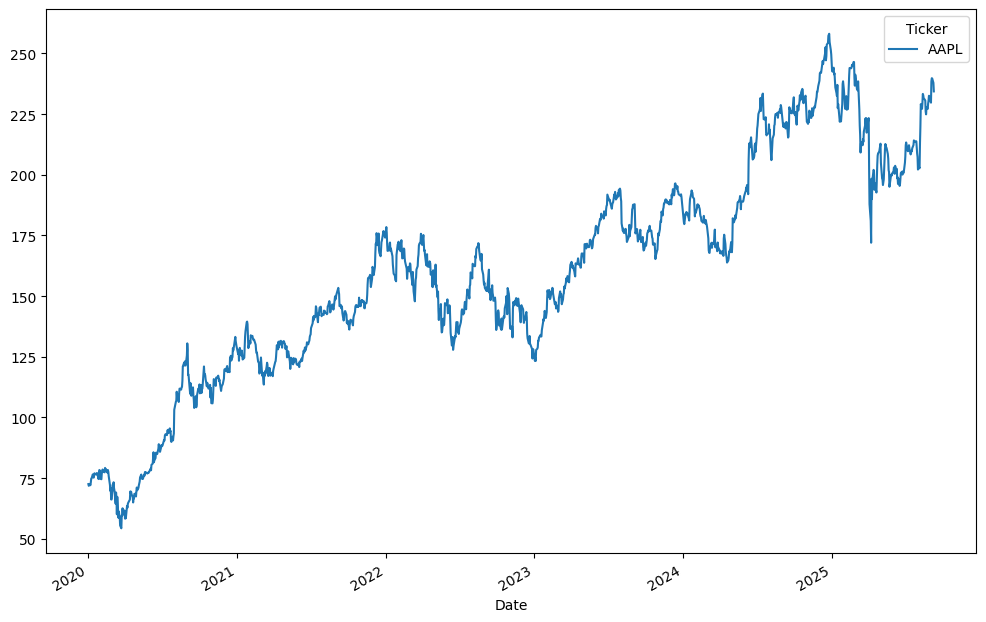

In [6]:
df["Close"].plot(figsize=(12, 8))

In [7]:
# SCALE FEATURES

features = ["Close", "Return", "MA5", "Volatility", "Momentum", "Volume"]
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])
df

Price,Close,Volume,Return,MA5,Volatility,Momentum
Ticker,AAPL,AAPL,,,,
Date,,,,,,
2020-01-02,-1.932902,0.945833,-0.050477,-1.930244,-1.464871,-0.087058
2020-01-03,-1.948555,1.155313,-0.528068,-1.930244,-1.464871,-0.087058
2020-01-06,-1.935851,0.615586,0.340958,-1.930244,-1.464871,-0.087058
2020-01-07,-1.943409,0.431748,-0.281514,-1.930244,-1.464871,-0.087058
2020-01-08,-1.917679,0.880121,0.739760,-1.933024,-0.586888,-0.087058
...,...,...,...,...,...,...
2025-09-03,1.749801,-0.388291,1.820629,1.628369,0.108590,1.289054
2025-09-04,1.778876,-0.753030,0.219375,1.669658,0.107492,1.308583


In [8]:
# CREATE SEQUENCES

seq_length = 30 # sequences of 30 consecutive closing prices
data = []
    
# loop from the first day to the day where we still have 30 days left
for i in range(len(df) - seq_length + 1):
    data.append(df[features].iloc[i:i + seq_length])
        
data = np.array(data) # shape: (num_sequences, seq_length, num_features)
data

array([[[-1.93290238, -0.05047684, -1.9302437 , -1.46487104,
         -0.08705836,  0.94583333],
        [-1.94855453, -0.52806795, -1.9302437 , -1.46487104,
         -0.08705836,  1.15531297],
        [-1.93585072,  0.34095791, -1.9302437 , -1.46487104,
         -0.08705836,  0.61558565],
        ...,
        [-1.82559975, -0.34685389, -1.81390833, -0.56450689,
         -0.03195631,  0.15065923],
        [-1.7848192 ,  1.11609972, -1.80690275, -0.20917069,
          0.14974348,  0.52561435],
        [-1.79733827, -0.40029265, -1.80644003, -0.21070855,
         -0.07141774,  0.15885882]],

       [[-1.94855453, -0.52806795, -1.9302437 , -1.46487104,
         -0.08705836,  1.15531297],
        [-1.93585072,  0.34095791, -1.9302437 , -1.46487104,
         -0.08705836,  0.61558565],
        [-1.94340866, -0.28151409, -1.9302437 , -1.46487104,
         -0.08705836,  0.43174806],
        ...,
        [-1.7848192 ,  1.11609972, -1.80690275, -0.20917069,
          0.14974348,  0.52561435],
  

In [9]:
# TRAIN TEST SPLIT

train_size = int(0.8 * len(data))

# torch.from_numpy changes numpy array into tensor
# take first 80% of the 30 day sequences
# cut out last day, keep the last dimension (Close value)
# .float() insures float-32 bit for compatibility
# to(device) ensures the tensors live in the same hardware as the model
X_train = torch.from_numpy(data[:train_size, :-1, :]).float().to(device)
y_train = torch.from_numpy(data[:train_size, -1, :1]).float().to(device) # only take the close price

# 20% test set
X_test = torch.from_numpy(data[train_size:, :-1, :]).float().to(device)
y_test = torch.from_numpy(data[train_size:, -1, :1]).float().to(device)

In [10]:
class PredictionModel(nn.Module):

    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout=0.2):
        # input data will have shape (batch_size, seq_length - 1, input_dim). in our case (1398, 29, 1)
        # in our case, input_dim = 1 (just Close price)
        # hidden_dim = 32 for example is the num features in each LSTM hidden state
        # num_layers = 2 would be the num of stacked LSTM layers
        # output_dim = 1 in our case because we're predicting one number (next day's closing price)
        
        super(PredictionModel, self).__init__()
        
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        # long short-term memory - type of recurrent neural network designed to work with sequence data
        # each cell (like a neuron) has h and c attributes, for output/working memory and long term memory, respectively
        # batch_first=True tells model that our input shape is (batch_size, seq_length - 1, input_dim)
        # the output of the LSTM layers would be size (batch_size, seq_length - 1, hidden_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)

        self.dropout = nn.Dropout(dropout)
        
        # maps the last hidden state (batch_size, hidden_dim) to (batch_size, output_dim)
        self.fc = nn.Linear(hidden_dim, output_dim) # fully connected hidden layer

    def forward(self, x):
        # x is size (batch_size, seq_length - 1, input_dim)
        
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device) # shape: (num_layers, batch_size, hidden_dim)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)

        # forward pass for the lstm
        # out: all hidden states across the sequence, shape: (batch_size, seq_length - 1, hidden_dim)
        # hn: the last hidden state for each layer, shape: (num_layers, batch_size, hidden_dim)
        # cn: the last cell state for each layer
        # use .detach() to not track gradients
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # out[:, -1, :] keeps all batches, picks the last timestep (index 28), and keeps all hidden features
        # last hidden state summarizes the info from the whole sequence
        # size (batch_size, hidden_dim)
        # feed through the fully connected hidden layer to get size (batch_size, output_dim)
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)

        return out

In [11]:
model = PredictionModel(input_dim=len(features), hidden_dim=40, num_layers=2, output_dim=1, dropout=0.15).to(device)

In [12]:
criterion = nn.MSELoss() # mean squared error
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.001)

In [13]:
num_epochs = 300

for epoch in range(num_epochs):
    model.train() # training mode
    optimizer.zero_grad() # reset gradients

    y_train_pred = model(X_train)
    train_loss = criterion(y_train_pred, y_train)
    
    train_loss.backward()
    optimizer.step()

    if epoch % 25 == 0:
        print(f"Epoch {epoch}: Train Loss = {train_loss.item():.4f}")

print(f"Epoch {epoch}: Train Loss = {train_loss.item():.4f}")

Epoch 0: Train Loss = 0.6335
Epoch 25: Train Loss = 0.0137
Epoch 50: Train Loss = 0.0087
Epoch 75: Train Loss = 0.0087
Epoch 100: Train Loss = 0.0081
Epoch 125: Train Loss = 0.0079
Epoch 150: Train Loss = 0.0079
Epoch 175: Train Loss = 0.0102
Epoch 200: Train Loss = 0.0075
Epoch 225: Train Loss = 0.0075
Epoch 250: Train Loss = 0.0069
Epoch 275: Train Loss = 0.0073
Epoch 299: Train Loss = 0.0111


In [14]:
# EVALUATION
model.eval()
with torch.no_grad():
    y_train_pred = model(X_train)
    y_test_pred = model(X_test)

def invert_scale(y_scaled):
    # Inverse scale to original price
    # scaler expects 3 columns, but y only has 1, so we concatenate two more columns of 0s. Then we take the 1st column (our close price pred) with [:, 0]
    return scaler.inverse_transform(
        np.concatenate([y_scaled.cpu().numpy(), np.zeros((y_scaled.shape[0], len(features) - 1))], axis=1)
    )[:, 0]

y_train_pred = invert_scale(y_train_pred)

y_train_real = invert_scale(y_train)

y_test_pred = invert_scale(y_test_pred)

y_test_real = invert_scale(y_test)

In [15]:
# Compute RMSE
train_rmse = np.sqrt(root_mean_squared_error(y_train_real, y_train_pred))
test_rmse = np.sqrt(root_mean_squared_error(y_test_real, y_test_pred))
print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)

Train RMSE: 1.7023730139824464
Test RMSE: 2.403368311332419


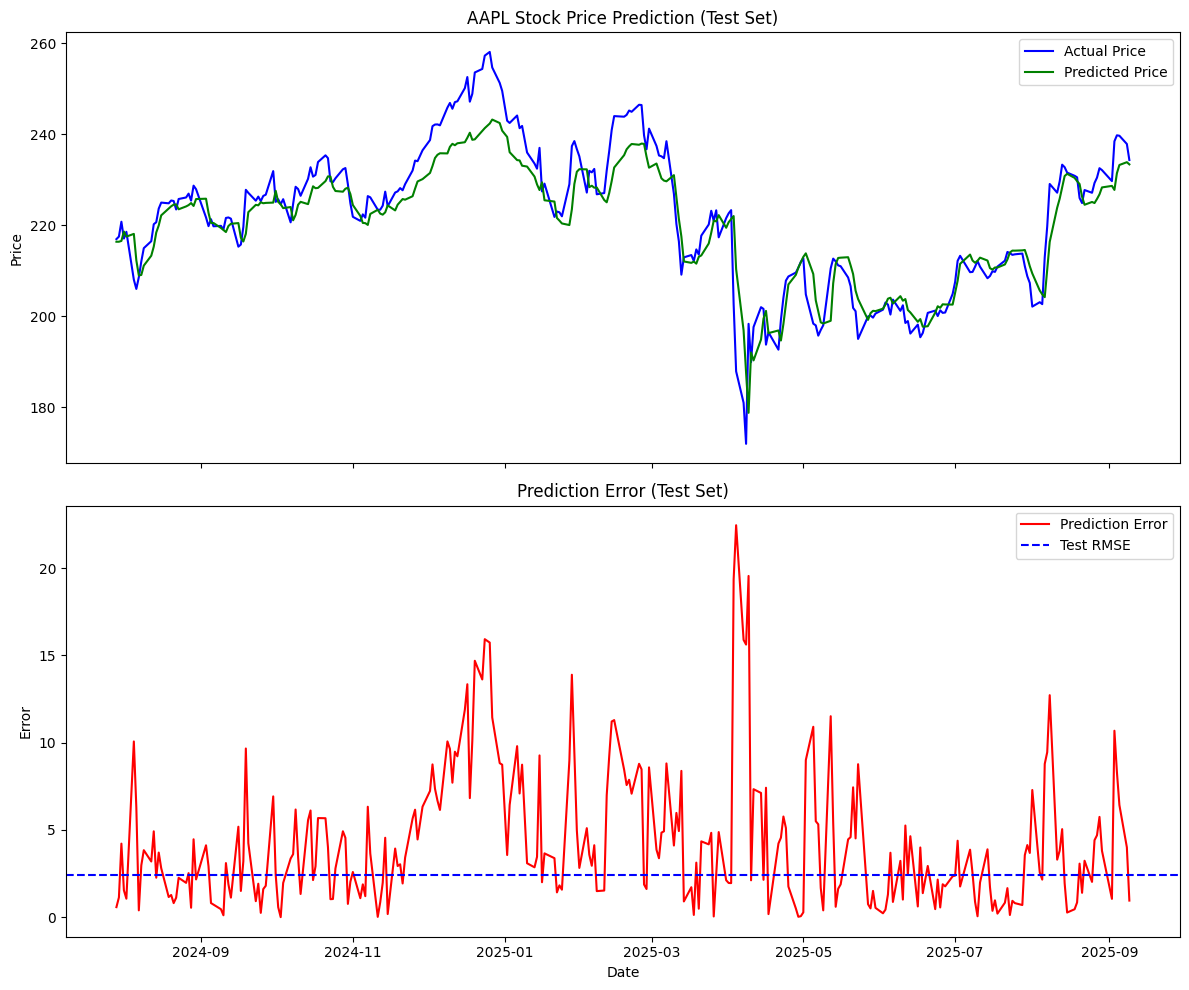

In [16]:
# PLOTTING
fig, ax = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Top: Prices (Test Only)
ax[0].plot(df.index[-len(y_test_real):], y_test_real, color='blue', label='Actual Price')
ax[0].plot(df.index[-len(y_test_pred):], y_test_pred, color='green', label='Predicted Price')
ax[0].legend()
ax[0].set_title(f"{ticker} Stock Price Prediction (Test Set)")
ax[0].set_ylabel("Price")

ax[1].plot(df.index[-len(y_test_real):], np.abs(y_test_real - y_test_pred), color='red', label='Prediction Error')
ax[1].axhline(test_rmse, color='blue', linestyle='--', label='Test RMSE')
ax[1].legend()
ax[1].set_title("Prediction Error (Test Set)")
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Error")

plt.tight_layout()
plt.show()
